### Импортируем библиотечки

In [1]:
%%capture
!pip install transformers focal_loss_torch opencv-python

In [2]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

albumentations==1.3.1 is successfully installed


In [ ]:
%cd

/home/innodatahub


In [ ]:
%%capture
!gdown 13X6J0enOo1m-MCbUvMt-lueWrdGXNnF0
!gdown 1HJqqXsw9OnM3nSRgAcqNy5ktqnqWPtfq
!gdown 1fkx3Hq0j0ItDz0z-OX36pAqFJ3k21NGm
!unzip /content/image_data.zip -d data

In [47]:
import pandas as pd
# import cv2
import os
import albumentations as A
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
# import optuna

from collections import defaultdict
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel
from collections import OrderedDict
from tqdm import tqdm
from PIL import Image
import torchvision.transforms as T
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

In [ ]:
torch.cuda.is_available()

True

In [ ]:
def display_image(img):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(img)
    ax.set_axis_off()
    plt.show()

### Определяем аугментации

In [99]:
train_transform = A.Compose([
    A.RandomCrop(width=160, height=160, p=0.3),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.4),
])

valid_transform = A.Compose([
    A.CenterCrop(width=160, height=160, p=0.3),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.4),
])

In [8]:
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [22]:
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [29]:
import pymorphy3
import math
import re
morph = pymorphy3.MorphAnalyzer()

stopwords_ru = stopwords.words("russian")
def preprocess_text(string):
  try:
    math.isnan(string)
    return ""
  except:
    string = string.lower()
    points_re = re.compile('[".,;/+]')
    backslash = re.compile(r"\\")
    double_wh = re.compile("  ")
    string = points_re.sub(repl="", string=string)
    string = double_wh.sub(repl=" ", string=string)
    string = backslash.sub(repl="", string=string)
    string = " ".join([morph.parse(word)[0].normal_form for word in string.split(" ") if word not in stopwords_ru])
    return string

### Определяем датасет

In [136]:
#сперва обработаем картинки
label2id = ["Развлечения и юмор", "Кулинария", "Торговля и объявления", "СМИ", "Философия и религия", "Животные", "Творчество и дизайн", "Путешествия"]
class make_dataset_(Dataset):
  def __init__(self, data_df, path_to_data, transform, mode="train"):
    self.path_to_data = path_to_data
    self.data = data_df.copy()
    self.data["id"] = self.data["id"].apply(lambda x: os.path.join(path_to_data, str(x)))
    self.mode = mode
    self.transform = transform
  def __getitem__(self, id):
    to_tensor = ToTensorV2()
    to_resize = T.Resize((224, 224))
    img = Image.open(self.data.iloc[id, 0])
    img = np.asarray(img.convert("RGB"))
    img = self.transform(image=img)["image"]
    img = to_resize(to_tensor(image=img)["image"])
    text = preprocess_text(self.data.iloc[id, 1])
    if self.mode == "train":
      label = self.data.iloc[id, 2]
      return img, text, label2id.index(label)
    else:
      return img, text
  def __len__(self):
    return len(self.data)

### Создаём датасет, сплитим, смотрим на распределение классов

In [137]:
data = pd.read_csv("/content/image_train.csv", sep=";")
data = data[data.label.isin(label2id)]
data.index = list(range(0, data.shape[0]))

train_df, valid_df = train_test_split(data, test_size=0.15, train_size=0.85)
valid_df.index = [i for i in range(len(valid_df))]
train_dset = make_dataset_(train_df, "/content/data/Train", train_transform)
valid_dset = make_dataset_(valid_df, "/content/data/Train", valid_transform)

In [131]:
train_dset[10][0].shape

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([3, 224, 224])

### Смотрим на аугментации

In [129]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _, _  = dataset[idx]
        ax.ravel()[i].imshow(image.permute(1, 2, 0))
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


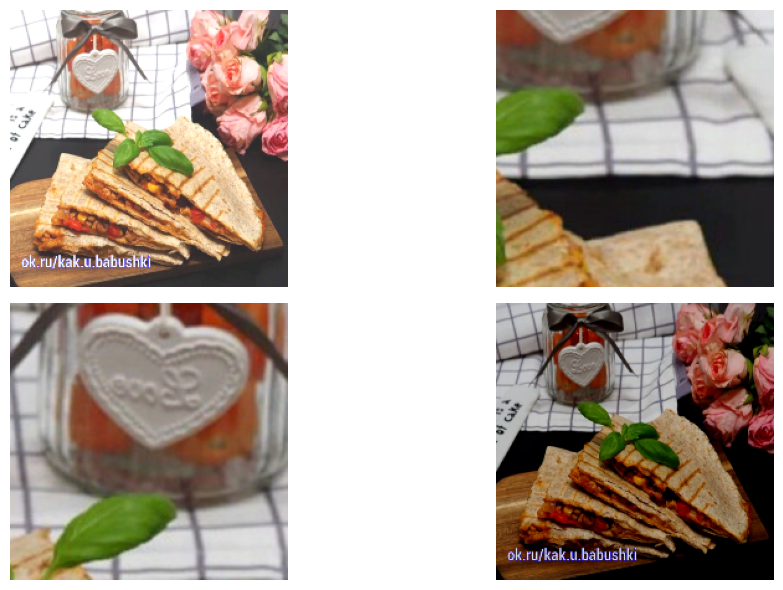

In [130]:
visualize_augmentations(train_dset, idx=10, samples=4, cols=2)

### Определяем класс для подсчёта метрик

In [87]:
def calculate_accuracy(output, target):
    train_accuracy = torch.sum(target == output) / len(target)
    return train_accuracy

class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [88]:
model_image = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

In [139]:
train_loader = DataLoader(
    train_dset, batch_size=16, shuffle=True, num_workers=1, pin_memory=True,
)
val_loader = DataLoader(
    valid_dset, batch_size=16, shuffle=False, num_workers=1, pin_memory=True,
)

In [144]:
for image, text, label in train_loader:
  input = processor(text=text, images=image, return_tensors="pt", padding=True)
  output = model_image(**input)
  print(output.logits_per_image.softmax(dim=1), output.logits_per_image.softmax(dim=1).shape)
  break

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor([[3.4875e-01, 8.6057e-02, 2.3523e-02, 5.4705e-03, 3.3262e-01, 1.8332e-03,
         2.3523e-02, 2.3523e-02, 2.3523e-02, 2.7379e-02, 2.8669e-02, 1.7260e-03,
         2.2884e-02, 2.0678e-02, 4.9740e-03, 2.4869e-02],
        [1.4422e-02, 3.0770e-01, 5.7687e-02, 8.7952e-03, 6.9754e-02, 4.3175e-02,
         5.7687e-02, 5.7687e-02, 5.7687e-02, 3.2070e-02, 5.2503e-02, 1.2905e-01,
         5.9394e-02, 2.9300e-02, 8.7238e-03, 1.4362e-02],
        [1.9377e-01, 3.4993e-02, 1.3602e-02, 1.1262e-02, 3.4325e-01, 7.3882e-03,
         1.3602e-02, 1.3602e-02, 1.3602e-02, 2.2046e-02, 3.1280e-02, 1.2537e-02,
         1.3977e-01, 4.2403e-02, 1.8899e-02, 8.7995e-02],
        [1.9027e-01, 1.7717e-01, 1.4678e-03, 5.8262e-02, 1.4547e-01, 1.1426e-04,
         1.4678e-03, 1.4678e-03, 1.4678e-03, 1.1666e-01, 9.0302e-02, 1.0259e-02,
         1.9969e-02, 5.5026e-02, 7.4439e-02, 5.6190e-02],
        [3.7885e-02, 9.0850e-03, 2.1822e-01, 3.2529e-03, 1.9785e-02, 1.9736e-02,
         2.1822e-01, 2.1822e-01, 2.1822

### Фунцкия для создания модели

In [ ]:
def create_model(trial):
    global model_image

    model_image = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

    # ln_middle_feat = trial.suggest_int("linear_middle_feat", 512, 800)
    # model_image.classifier = nn.Sequential(OrderedDict([
    #     ("ln1", nn.Linear(1280, ln_middle_feat, bias=True)),
    #     ("dp2", nn.ReLU()),
    #     ("ln2", nn.Linear(ln_middle_feat, 8, bias=True)),
    #     ("act2", nn.ReLU()),
    # ]))

    # for p in model_image.parameters():
    #     p.requires_grad = False

    # count_of_unfrozen = trial.suggest_int("count_of_unfrozen", 1, 16)
    # for i in range(16 - count_of_unfrozen, 16):
    #   for p in getattr(model_image.efficientnet.encoder.blocks, str(i)).parameters():
    #     p.requires_grad = True

    # was_true = 0
    # for p in model_image.parameters():
    #   if p.requires_grad == False and was_true == 0: continue
    #   elif p.requires_grad == True:
    #     was_true = 1
    #   else: p.requires_grad = True
    # return model_image


### Функции трейна и валидации

In [ ]:
# from sklearn.metrics import f1_score
def train(train_loader, model, criterion, optimizer, epoch, device):
    metric_monitor = MetricMonitor(float_precision=4)
    model.train()
    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)
        output = model(images)["logits"]
        output = torch.nn.functional.softmax(output, dim=1)
        loss = criterion(output, target)
        output = torch.argmax(output, dim=1).to(torch.int64)
        accuracy = calculate_accuracy(output, target)
        f1 = calculate_f1(output, target)
        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Accuracy", accuracy)
        metric_monitor.update("F1", f1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

In [ ]:
def validate(val_loader, model, criterion, epoch, device):
    metric_monitor = MetricMonitor(float_precision=4)
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True)
            output = model(images)["logits"]
            output = torch.nn.functional.softmax(output, dim=1)
            loss = criterion(output, target)
            output = torch.argmax(output, dim=1).to(torch.int64)
            accuracy = calculate_accuracy(output, target)
            f1 = calculate_f1(output, target)
            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", accuracy)
            metric_monitor.update("F1", f1)
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )
    return metric_monitor.metrics["F1"]["avg"], metric_monitor.metrics["Accuracy"]["avg"]

### Objective Функция

In [ ]:
def objective(trial):
    lr_base = trial.suggest_categorical("lr_base", [2e-4, 3e-4, 2e-5])
    optimizer = trial.suggest_categorical("optimizer", ["Adam", "Adagrad", "RMSprop"])

    device = torch.device("cuda")
    model = create_model(trial).to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = getattr(torch.optim, optimizer)(model.parameters(), lr=lr_base)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

    train_loader = DataLoader(
        train_dset, batch_size=64, shuffle=True, num_workers=1, pin_memory=True,
    )
    val_loader = DataLoader(
        valid_dset, batch_size=64, shuffle=False, num_workers=1, pin_memory=True,
    )

    for epoch in range(1, 21):
        train(train_loader, model, criterion, optimizer, epoch, device)
        f1, acc = validate(val_loader, model, criterion, epoch, device)

        scheduler.step(acc)

        trial.report(f1, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return f1

### Оптимизируем модель

In [ ]:
import time
from IPython.display import clear_output

num_epochs = 1

def callback(study, trial):
    global best_model
    if study.best_trial == trial:
        best_model = model_image

def clean_stream(study, trial):
    global num_epochs
    clear_output(wait=True)
    num_epochs += 1
    print(num_epochs)

start_time = time.time()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, callbacks=[callback, clean_stream])

end_time = time.time()
took_time =  end_time - start_time

3


Epoch: 1. Train.      Loss: 1.9579 | Accuracy: 0.4411 | F1: 0.2541: 100%|██████████| 66/66 [00:19<00:00,  3.46it/s]
Epoch: 1. Validation. Loss: 1.8879 | Accuracy: 0.4620 | F1: 0.2991: 100%|██████████| 12/12 [00:04<00:00,  2.79it/s]
Epoch: 2. Train.      Loss: 1.8459 | Accuracy: 0.5219 | F1: 0.3505: 100%|██████████| 66/66 [00:18<00:00,  3.52it/s]
Epoch: 2. Validation. Loss: 1.8418 | Accuracy: 0.5604 | F1: 0.3970: 100%|██████████| 12/12 [00:04<00:00,  2.50it/s]
Epoch: 3. Train.      Loss: 1.8187 | Accuracy: 0.5393 | F1: 0.3685: 100%|██████████| 66/66 [00:18<00:00,  3.55it/s]
Epoch: 3. Validation. Loss: 1.8231 | Accuracy: 0.5465 | F1: 0.3843: 100%|██████████| 12/12 [00:05<00:00,  2.32it/s]
Epoch: 4. Train.      Loss: 1.7976 | Accuracy: 0.5533 | F1: 0.3869: 100%|██████████| 66/66 [00:18<00:00,  3.49it/s]
Epoch: 4. Validation. Loss: 1.8052 | Accuracy: 0.5501 | F1: 0.3766: 100%|██████████| 12/12 [00:04<00:00,  2.85it/s]
Epoch: 5. Train.      Loss: 1.7855 | Accuracy: 0.5753 | F1: 0.4064: 100%

In [ ]:
print(f"This took {took_time // 60} minutes and {took_time - (took_time // 60)} seconds")
print()
print("best trial: ", study.best_trial)
print()
print("best_score: ", study.best_value)
print()
print("best_params: ", study.best_params)

In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()